In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn

from helpers import *
from torch.autograd import Variable
from random import shuffle

%matplotlib inline

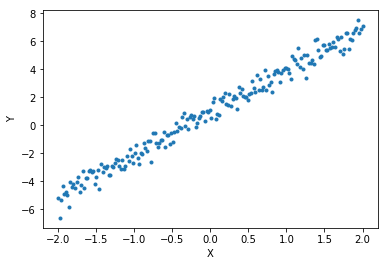

In [2]:
N = 200  # size of toy data

def build_linear_dataset(N, noise_std=0.5):
    X = np.linspace(-2, 2, num=N)
    Y = 3 * X + 1 + np.random.normal(0, noise_std, size=N)
    X, Y = X.reshape((N, 1)), Y.reshape((N, 1))
    return X, Y

X, Y = build_linear_dataset(N)

X_var = Variable(torch.Tensor(X))
Y_var = Variable(torch.Tensor(Y))

plt.plot(X, Y, '.');
plt.xlabel('X');
plt.ylabel('Y');

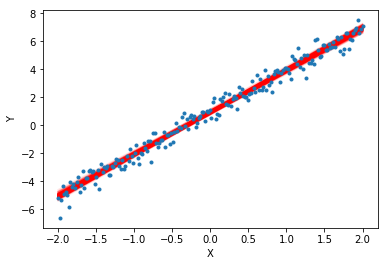

In [3]:
# posterior with bayesian linear regression

alpha = 0.01  # precision of isotropic Gaussian prior on weight
betam = 1.    # precision of model noise

m0 = 0.
S0 = 1/alpha*np.eye(2)
Phi = np.array([X.squeeze(), 
                np.ones((len(X)))]).T

SN = np.linalg.inv(alpha+betam*np.dot(Phi.T, Phi))
mN = betam*np.dot(SN, np.dot(Phi.T, Y))

for r in range(250):
    sampam = np.random.multivariate_normal(mN.squeeze(), SN, 1)
    plt.plot(X, np.dot(sampam.squeeze(), np.array([X, 1])), '-r', alpha=0.1)
plt.plot(X, Y, '.');
plt.xlabel('X');
plt.ylabel('Y');

In [55]:
model = MDN(svi=True, n_samples=1000)
optim = torch.optim.Adam(model.parameters(), lr=0.01)

def train(X, Y, n_epochs=100, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))
            y_var = Variable(torch.Tensor(y_batch))
                                                            
            (out_alpha, out_sigma, out_mu) = model(x_var)
            
            if model.svi:
                y_var = y_var[None, :, :].expand(model.n_samples, x_var.size()[0], 1).contiguous().view(-1, 1)
            loss = -torch.mean(mdn_logloss(out_alpha, out_sigma, out_mu, y_var))
            loss += 1/N*mdn_kl(model.mu, model.logsigma, 0.01)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

        if (epoch + 1) % 50 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))
        
train(X, Y)

[epoch 0050] loss: 1.6783
[epoch 0100] loss: 1.4550


In [ ]:
def normal_loglikelihood(mu, sd):
    def logp(x):
        return -0.5* ((x - mu) / sd)**2 - 0.5 * tt.log(2* np.pi) - tt.log(sd)
    return logp


def make_fun(): 
    eval = theano.function(
        inputs=[emul.network.params, emul.network.stats],
        outputs=[f_theta, fprime_theta],
        on_unused_input='ignore')
    def fun(x, t):
        f, g = eval(x, t)
        return np.array((f, g), dtype=dtype)    
    return fun

def make_invoke(M):
    def invoke(x, theta):
        v = np.zeros(M, dtype=dtype)
        for m in range(M):
            v[m] = fun(x, theta)
        return v
    return invoke

def loss(v, beta):
    Ef = v['f'].mean()
    Ef2 = (v['f']**2).mean()
    E2f = Ef**2
    return -Ef - beta * (Ef2 - E2f)

def grad(v, beta):
    return -(np.mean(v['g']) + 2 * beta * (np.dot(v['f'], v['g'])/M - np.mean(v['f'])*np.mean(v['g'])))

def optimize(f, po, maxiter=150, verbose=False):
    to, xo = po
    alpha = 0.01
    done = False
    ti = to
    Lo = np.inf
    i = 0
    
    if verbose:
        pbar = tqdm()
    
    while not done and i < maxiter:
        vi = f(xo, ti)
        L = loss(vi, beta)
        g = grad(vi, beta)
        #print(ti, g)
        assert not np.isinf(g)
        assert not np.isnan(g)
        
        ti -= alpha * g
        if np.abs(Lo - L) < 1e-6 * Lo + 1e-6:
            done = True
        Lo = L
        i += 1
        
        if verbose:
            pbar.update()
    return ti

M = 100
beta = 1.

def al_objective_v1():
    # C(θ) = E[log L(θ)p(θ)] + β VAR[log L(θ)p(θ)]
    f  = mdn_logprobs()
    f += gauss_pdf()
    return f



obs = np.array([0.8])
theta_init = np.array([0.])

t_star = optimize(make_invoke(M), (theta_s, obs))
t_star



In [56]:
dataset_train = [(x, y) for x, y in zip(X, Y)]
bgen = batch_generator(dataset_train, 50)
x_batch, y_batch = next(bgen)
x_var = nn.Parameter(torch.Tensor(x_batch))
y_var = Variable(torch.Tensor(y_batch))
(out_alpha, out_sigma, out_mu) = model(x_var, frozen=True)
y_var = y_var[None, :, :].expand(model.n_samples, x_var.size()[0], 1).contiguous().view(-1, 1)
loss = mdn_loss_function(out_alpha, out_sigma, out_mu, y_var)
loss.backward()

In [84]:
beta = 1.

tic = time.time()
x_var = nn.Parameter(torch.Tensor(x_batch))
(out_alpha, out_sigma, out_mu) = model(x_var, frozen=False)
y_var = Variable(torch.Tensor(y_batch))
y_var = y_var[None, :, :].expand(model.n_samples, x_var.size()[0], 1).contiguous().view(-1, 1)
loss = mdn_loss_function(out_alpha, out_sigma, out_mu, y_var)
new_loss = loss + 10.

f_theta = new_loss
print(f_theta)
#f_theta.backward()
#fprime_theta = x_var.grad.data.numpy()

diff = time.time() - tic
print(diff*1000)

Variable containing:
 11.2790
[torch.FloatTensor of size 1]

65.54293632507324


In [8]:
np.sum(fprime_theta)

NameError: name 'fprime_theta' is not defined

In [40]:
f_theta

Variable containing:
 11.0496
[torch.FloatTensor of size 1]

In [41]:
fprime_theta

Variable containing:
1.00000e-02 *
 -1.8378
  3.4964
 -0.3011
 -1.0284
  0.9547
  0.4381
  1.6746
 -2.3998
 -0.1852
 -0.9466
 -1.3031
  0.0271
 -2.7386
  0.7637
 -3.3172
  2.7550
 -2.2560
  0.3317
 -1.2224
  4.0281
  1.6371
  2.0536
 -3.5089
  3.4752
  0.5526
 -4.0975
  0.8461
 -0.5840
  2.8463
 -3.5889
  1.5361
 -3.3684
  6.3710
 -1.2141
 -2.2897
  1.5078
 -0.8305
 -6.4750
 -0.6231
  0.1070
  0.0917
  3.8521
  1.2610
 -1.3358
  1.2982
 -2.8053
  0.1178
  3.0380
  2.1547
  2.7982
[torch.FloatTensor of size 50x1]

In [37]:
x_var.grad

Variable containing:
1.00000e-02 *
 -1.7783
  3.6889
 -0.1117
 -0.8575
  1.1791
  0.6266
  1.8504
 -2.2394
 -0.0146
 -0.7090
 -1.1069
  0.0566
 -2.5219
  0.9384
 -3.1118
  2.9494
 -1.9808
  0.4872
 -0.9755
  4.1082
  1.6571
  2.2650
 -3.3962
  3.6917
  0.7768
 -3.8761
  0.8543
 -0.4225
  2.9789
 -3.6050
  1.6688
 -3.2006
  6.5004
 -1.1017
 -2.0681
  1.5124
 -0.6741
 -6.4668
 -0.4700
  0.2142
  0.3234
  3.9616
  1.3528
 -1.1151
  1.5155
 -2.5344
  0.2830
  3.2271
  2.2321
  3.0069
[torch.FloatTensor of size 50x1]

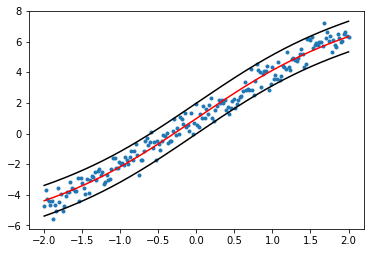

In [18]:
X_var = Variable(torch.Tensor(X))
Y_var = Variable(torch.Tensor(Y))

(out_alpha, out_sigma, out_mu) = model(X_var, sample=False)

plt.plot(X, Y, '.')
plt.plot(X, out_mu.data.numpy(), '-r');
plt.plot(X, out_mu.data.numpy() + out_sigma.data.numpy(), '-k');
plt.plot(X, out_mu.data.numpy() - out_sigma.data.numpy(), '-k');